# Imports

In [1]:
import os
import cv2
import torch
import imageio
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim

import torchvision.utils as vutils

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [9]:
# Number of channels
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 1
# Size of feature maps in generator
ngf = 100
# Size of feature maps in discriminator
ndf = 100
ngpu = 1
beta1 = 0.5
lr = 1e-3
batch_size = 100

# Implementation

In [10]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 3, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 3, ngf * 2, kernel_size=(4, 4), stride=(2, 2)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf* 2, ngf, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=(3, 3), stride=(1, 1), bias=False),
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ngf, kernel_size=(3, 3), stride=(1, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf, ngf * 2, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 2, ngf * 3, kernel_size=(4, 4), stride=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 3, ngf * 4, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, ngf * 4, kernel_size=(4, 4), stride=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf * 4, 1, kernel_size=(3, 3), stride=(2, 2)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

lr = 1e-3

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 10, 10, device=device)


# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(400, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(400, 300, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(300, 200, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(200, 100, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(100, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(200, 300, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(300, 400, kern

# Data

In [12]:
# Chemin vers le répertoire contenant les fichiers NetCDF
directory = './2008_2017_bis/Radar/1zone_100kmx100km/'

# Initialiser les tableaux pour X et y
X_all = []
y_all = []

# Parcourir les fichiers du répertoire
for filename in os.listdir(directory):
    if filename.endswith(".nc") and '200804' in filename:  # Filtrer les fichiers de 2008
        # Charger le fichier NetCDF
        data = xr.open_dataset(os.path.join(directory, filename))
        # Extraire les données X et y
        X = np.array(data.variables['monthlypdsi'])
        y = np.array(data.Time)
        # Ajouter les données à X_all et y_all
        X_all.append(X)
        y_all.append(y)

# Concaténer les tableaux X_all et y_all
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

In [13]:
num_epochs = 100

loss_D_epoch = []
loss_G_epoch = []

# Lists to keep track of progress
img_list = []
test = []
G_losses = []
D_losses = []
iters = 0


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    np.random.shuffle(X_all)
    real_samples = torch.from_numpy(X_all).type(torch.FloatTensor)
    errD = 0
    errG = 0
    for i, data in enumerate(real_samples.split(batch_size)):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device).unsqueeze(1)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        label = torch.full((output.size(0),), real_label, dtype=torch.float, device=device)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(output.shape[0], nz, 4, 4, device=device) # modèle de Charlie
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(data)}]\tLoss_D: {round(errD.item(),3)}\tLoss_G: {round(errG.item(),3)}\tD(x): {round(D_x,3)}\tD(G(z)): {round(D_G_z1,3)} / {round(D_G_z2,3)}')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if iters%10 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            test.append(fake)
            img_list.append(vutils.make_grid(fake, nrow = 10, padding=0, normalize=True))
        #img_list.append(vutils.make_grid(fake, padding=0, normalize=True))
        iters += 1

Starting Training Loop...
[1/100][0/100]	Loss_D: 1.387	Loss_G: 0.108	D(x): 0.496	D(G(z)): 0.496 / 0.898
[2/100][0/100]	Loss_D: 100.219	Loss_G: 0.0	D(x): 0.819	D(G(z)): 1.0 / 1.0
[3/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[4/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[5/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[6/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[7/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[8/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[9/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[10/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[11/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[12/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[13/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 1.0	D(G(z)): 1.0 / 1.0
[14/100][0/100]	Loss_D: 100.0	Loss_G: 0.0	D(x): 

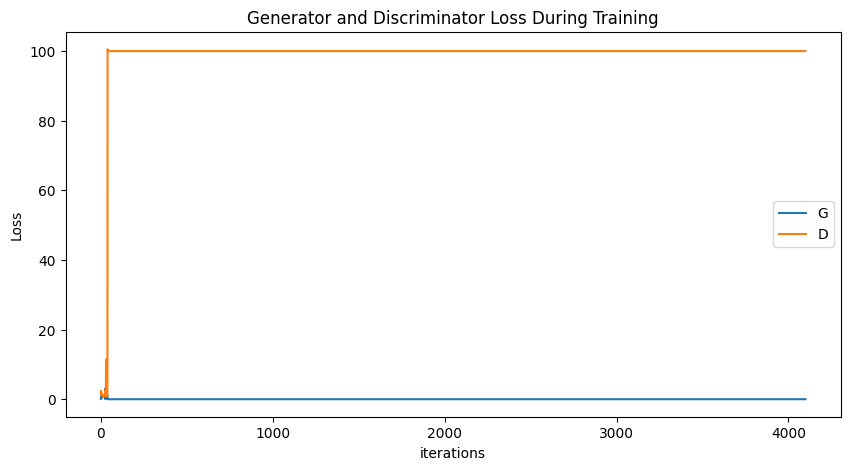

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
#plt.show()
plt.savefig('DG.png')

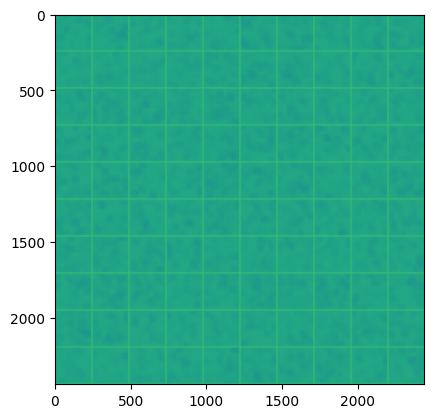

In [15]:
plt.imshow(img_list[30][0][:,:])